In [37]:
import os

data_path = os.getcwd()
# train path
train_images_path = os.path.join(data_path, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_path, 'train-labels-idx1-ubyte.gz')
# test path
test_images_path = os.path.join(data_path, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_path, 't10k-labels-idx1-ubyte.gz')

def get_mnist_data(images_path, labels_path, num_images
                   , shuffle=False, _is=True, image_size=28):
    """
        This shuffle param is active when .gz is downloaded at:
            - 'http://yann.lecun.com/exdb/mnist/'
            - This function return random num_images in 60000 or 10000 :D 
    """
    # read data
    import gzip
    import numpy as np

    f_images = gzip.open(images_path,'r')
    f_images.read(16)
    
    real_num = num_images if not shuffle else (60000 if _is else 10000)

    buf_images = f_images.read(image_size * image_size * real_num)
    
    # images
    images = np.frombuffer(buf_images, dtype=np.uint8).astype(np.float32)
    images = images.reshape(real_num, image_size, image_size,)
    
    # labels   
    f_labels = gzip.open(labels_path,'r')
    f_labels.read(8)
    
    labels = np.zeros((real_num)).astype(np.int64)
    for i in range(0, real_num):   
        buf_labels = f_labels.read(1)
        labels[i] = np.frombuffer(buf_labels, dtype=np.uint8).astype(np.int64)
    
    if shuffle is True:
        rand_id = np.random.randint(real_num, size=num_images)
        
        images = images[rand_id, :]
#         images = images.reshape(num_images, image_size * image_size)
        labels = labels[rand_id,]
    
    images = images.reshape(num_images, image_size * image_size)
    return images, labels

train_images, train_labels = get_mnist_data(
    train_images_path, train_labels_path, 5000, shuffle=True)

test_images, test_labels = get_mnist_data(
    test_images_path, test_labels_path, 1000, _is=False, shuffle=False)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(5000, 784) (5000,)
(1000, 784) (1000,)


In [38]:
def convert_labels(y, C):
    from scipy import sparse 
    Y = sparse.coo_matrix((np.ones_like(y), 
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y 

def softmax_stable(Z):
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def pred(W, X):
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

0 8


<Figure size 432x288 with 0 Axes>

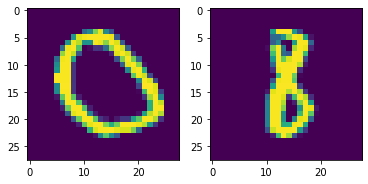

In [39]:
# for display and test digit :D 
import random
import numpy as np

index = random.randint(0, 1000)
print(train_labels[index], test_labels[index])

def get_image(image):
    return image.reshape(28, 28)

import matplotlib.pyplot as plt
train_image = np.asarray(get_image(train_images[index])).squeeze()
test_image = np.asarray(get_image(test_images[index])).squeeze()

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, 2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(train_image)
axarr[1].imshow(test_image)
plt.show()

In [40]:
X_train = np.concatenate((np.ones((1, train_images.shape[0])), train_images.T), axis = 0)
Y_train = convert_labels(train_labels, 10)
print(X_train.shape)
print(Y_train.shape)

X_test = np.concatenate((np.ones((1, test_images.shape[0])), test_images.T), axis = 0)
Y_test = convert_labels(test_labels, 10)
print(X_test.shape)
print(Y_test.shape)

(785, 5000)
(10, 5000)
(785, 1000)
(10, 1000)


In [41]:
def _softmax_regression(X, Y, theta, lambda_=0.5,
                       iterations=20, learning_rate=1e-5, batch_size=200):
    from sklearn.metrics import log_loss
    
    losses = []
    _theta = theta
    d, N = X.shape
    
    for iter_ in range(iterations):
        shuffle_index = np.random.permutation(N)
        for i in shuffle_index:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(10, 1)
            ai = softmax_stable(np.dot(_theta.T, xi))
            _theta += learning_rate * xi.dot((yi - ai).T)
            if (iter_ * N + i) % batch_size == 0:
                Y_hat = np.dot(_theta.T, X)
                losses.append(log_loss(Y, Y_hat))
                
        Y_hat = np.dot(_theta.T, X)
        print(f"epoch {iter_} - cost {log_loss(Y, Y_hat)}")
                
    return _theta, losses
    

theta = np.zeros((X_train.shape[0], 10))

opt_theta, losses = _softmax_regression(X_train, Y_train, theta)
print('training success: ', opt_theta.shape, len(losses))


epoch 0 - cost 3959.3055050856433
epoch 1 - cost 3936.487121049397
epoch 2 - cost 3922.3790422538805
epoch 3 - cost 3898.343258436887
epoch 4 - cost 3900.284637499414
epoch 5 - cost 3912.8263835263087
epoch 6 - cost 3913.4469545396073
epoch 7 - cost 3883.2856917609033
epoch 8 - cost 3893.6779730347384
epoch 9 - cost 3889.4426134290616
epoch 10 - cost 3881.6648348219037
epoch 11 - cost 3892.2791820827442
epoch 12 - cost 3891.2351795898803
epoch 13 - cost 3894.909441561968
epoch 14 - cost 3897.7452787156026
epoch 15 - cost 3893.079059931424
epoch 16 - cost 3891.7605485928334
epoch 17 - cost 3895.052847468441
epoch 18 - cost 3893.684690818707
epoch 19 - cost 3897.7224973415664
training success:  (785, 10) 500


In [42]:
from sklearn.metrics import accuracy_score
print('accuracy training data: ', accuracy_score(train_labels, pred(opt_theta, X_train)))
print('accuracy testing data: ', accuracy_score(test_labels, pred(opt_theta, X_test)))

accuracy training data:  0.9598
accuracy testing data:  0.859


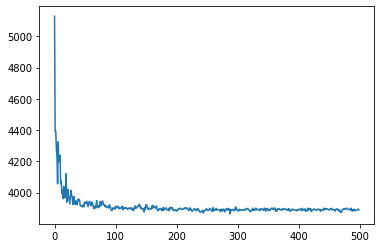

In [43]:
# display losses plot
plt.plot(losses)